# Extending VAEs!

## Table of Contents
1. [VQ-VAE](#VQ-VAE)
2. [Hierarchical VAE](#Hierarchical-VAE)
3. [VAE with Simple Waveform](#VAE-with-Simple-Waveform)

In [1]:
import librosa, os #audio processing and file system parsing
import librosa.display
import numpy as np #math library
import tensorflow as tf #for model building
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt # for visualization
import pandas as pd #for data analysis / prep
import IPython.display as ipd #for sound output
from scipy.spatial.distance import cosine

import soundfile as sf
os.makedirs("output", exist_ok=True)

2025-03-17 14:25:26.776584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 14:25:26.807274: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 14:25:27.180073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 14:25:27.508732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742235927.794801    1370 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742235927.84

Before we get into it, let's load some of the core functions and data from our previous notebooks.

In [2]:
# Define hop_length (adjust as needed)
HOP_LENGTH = 512
TIME_FRAMES = 1280  # Instead of 1290
N_MELS = 256
def load_data(audio_dir, n_mels=N_MELS, time_frames=TIME_FRAMES):
    """Processes a directory of audio files into a DataFrame containing the spectrograms and original waveforms."""
    audio_files = os.listdir(audio_dir)
    audio_data = {'filename': [], 'gt_audio': [], 'gt_spectrogram': [], 'min_max': []}

    for file in audio_files:
        try:
            original_audio, sampling_rate = librosa.load(os.path.join(audio_dir, file), sr=22050)  

            mel_spectrogram = librosa.feature.melspectrogram(y=original_audio, sr=sampling_rate, n_mels=n_mels, hop_length=HOP_LENGTH)
            S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Normalize based on max power
            
            # Save min/max values for proper denormalization later
            S_dB_min = np.min(S_dB)
            S_dB_max = np.max(S_dB)
            
            # Normalize to [0,1]
            S_dB = (S_dB - S_dB_min) / (S_dB_max - S_dB_min)

            # **Truncate or pad spectrogram to $time frames**
            if S_dB.shape[1] < TIME_FRAMES:
                pad_width = TIME_FRAMES - S_dB.shape[1]
                S_dB = np.pad(S_dB, pad_width=((0, 0), (0, pad_width)), mode='constant')
            elif S_dB.shape[1] > TIME_FRAMES:
                S_dB = S_dB[:, :TIME_FRAMES]
                
            # Store data
            audio_data['filename'].append(file)
            audio_data['gt_audio'].append(original_audio)
            audio_data['gt_spectrogram'].append(S_dB)
            audio_data['min_max'].append((S_dB_min, S_dB_max))  # Save for denormalization
        
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")
    
    return pd.DataFrame(audio_data)

def reconstruct_audio(spectrogram, sr=22050, n_mels=N_MELS, min_max=None):
    """Reconstructs audio from a normalized Mel spectrogram. Utilizes parameters from normalization to reverse process!"""
    spectrogram = np.array(spectrogram)
    S_dB_min, S_dB_max = min_max
    S_dB = spectrogram * (S_dB_max - S_dB_min) + S_dB_min  # Reverse normalization

    # Convert back to power spectrogram (ensure this transformation is correct)
    S = librosa.db_to_power(S_dB)  

    # Convert Mel spectrogram back to waveform
    reconstructed_audio = librosa.feature.inverse.mel_to_audio(S, sr=sr, hop_length=HOP_LENGTH)  
    return reconstructed_audio


jazz_df = load_data("../data/kaggle/genres_original/jazz/")
jazz_songs = np.array(jazz_df['gt_spectrogram'].tolist()) #transform song shapes
jazz_df.head()

/tmp/ipykernel_1370/298290904.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  original_audio, sampling_rate = librosa.load(os.path.join(audio_dir, file), sr=22050)
/home/seansteinle/.pyenv/versions/3.10.16/envs/cs757-p1/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping file jazz.00054.wav due to error: 


,filename,gt_audio,gt_spectrogram,min_max
0,jazz.00080.wav,"[-0.010284424, -0.018707275, -0.014312744, -0....","[[0.5306781, 0.5076559, 0.30387545, 0.19764082...","(-72.97773, 0.0)"
1,jazz.00098.wav,"[-0.031066895, -0.05078125, -0.04537964, -0.04...","[[0.5447164, 0.46910134, 0.44315043, 0.4229424...","(-80.0, 0.0)"
2,jazz.00001.wav,"[0.0024108887, 0.005493164, 0.008666992, 0.011...","[[0.5821481, 0.5379497, 0.44007826, 0.49471942...","(-80.0, 0.0)"
3,jazz.00069.wav,"[-0.029541016, -0.07070923, -0.10971069, -0.13...","[[0.64533484, 0.57680035, 0.38201648, 0.383343...","(-80.0, 0.0)"
4,jazz.00050.wav,"[-0.13595581, -0.09390259, -0.06210327, -0.216...","[[0.71702677, 0.64992064, 0.6152149, 0.6068060...","(-76.36797, 0.0)"


## VQ VAE


Here is how we extend the standard VAE by introducing the discrete latent variables (instead of continous ones).

In [3]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Layer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

from scipy.spatial.distance import cosine

In [4]:
# ---- VECTOR QUANTIZER ---- #
class VectorQuantizer(Layer):
    """ Implements the vector quantization layer, which maps continuous latent representations
        to discrete embeddings from a learned codebook. This layer enables discrete latent learning.
    """
    def __init__(self, num_embeddings, embedding_dim, beta, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta  # Commitment cost to ensure latent representations remain close to embeddings

        # Initialize the embedding codebook with uniform distribution
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        """ Performs vector quantization by mapping continuous inputs to their closest embeddings. """
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])  # Flatten input to match embedding dimension

        # Compute nearest embedding index
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)  # Convert to one-hot representation
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)  # Retrieve nearest embeddings

        quantized = tf.reshape(quantized, input_shape)

        # Compute vector quantization loss (encouraging commitment to embeddings)
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator: Pass gradients through quantized values
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        """ Computes distances between input features and embedding vectors to find closest match. """
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Identify nearest embedding indices based on minimal distance
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

# ---- MODEL CREATION ---- #
def get_encoder(latent_dim):
    """ Defines the encoder network that compresses the input spectrogram into a lower-dimensional latent space. """
    encoder_inputs = keras.Input(shape=(256, 1280, 1))  
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(encoder_inputs)
    x = LayerNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = LayerNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = LayerNormalization()(x)
    encoder_outputs = layers.Conv2D(latent_dim, (1, 1), padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

def get_decoder(latent_dim):
    """Defines a decoder that mirrors the encoder's upsampling path correctly."""
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])

    x = layers.Conv2DTranspose(256, (3, 3), activation="relu", strides=(2, 2), padding="same")(latent_inputs)  
    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same")(x) 
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)  

    # Final layer to reconstruct input spectrogram
    x = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x) 

    return keras.Model(latent_inputs, x, name="decoder")

def get_vqvae(latent_dim, num_embeddings, beta):
    """ Assembles the VQ-VAE model by integrating the encoder, vector quantizer, and decoder. """
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, beta, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    
    inputs = keras.Input(shape=(256, 1280, 1))  # Spectrogram input
    encoder_outputs = encoder(inputs)  # Compress input into latent space
    quantized_latents = vq_layer(encoder_outputs)  # Discretize latent representations
    reconstructions = decoder(quantized_latents)  # Reconstruct spectrogram

    return keras.Model(inputs, reconstructions, name="vq_vae")

class VQVAETrainer(keras.models.Model):
    """ Custom training loop for VQ-VAE to compute losses and update embeddings. """
    def __init__(self, train_variance, latent_dim, num_embeddings, beta, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance  # Variance of training data (used for normalization)
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings, beta)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name="vqvae_loss")

    @property
    def metrics(self):
        """ Returns tracked metrics for training evaluation. """
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.vq_loss_tracker]

    def train_step(self, x):
        """ Performs a single training step, including forward pass, loss computation, and optimization. """
        with tf.GradientTape() as tape:
            x = tf.expand_dims(x, axis=-1)  
            reconstructions = self.vqvae(x)  # Forward pass through the VQ-VAE model

            # Compute reconstruction loss (MSE) normalized by training variance
            reconstruction_loss = tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            total_loss = reconstruction_loss + sum(self.vqvae.losses)  # Total loss includes VQ loss

        # Compute gradients and update model parameters
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Update tracked loss metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

###  Balancing latent dimension, num_embeddings, and commitment loss is challenging. Fine-tuning these hyperparameters is essential for stable and expressive representations.

Higher commitment loss ==> Stronger pull towards embeddings, increasing VQ loss but improving discrete representation

Lower commitment loss ==> Weaker pull, reducing VQ loss, but risking unstable training

Low latent dim / shallow model ==> Insufficient capacity, failing to capture complex structures

High latent dim ==> Better representation, but risks overfitting or codebook collapse if num_embeddings is too low


2025-03-17 14:25:48.595861: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "vq_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 1280, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32, 160, 128)   │       403,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vector_quantizer                │ (None, 32, 160, 128)   │             0 │
│ (VectorQuantizer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 1280, 1)   │       664,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,033 (4.07 MB)

 Trainable params: 1,068,033 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - loss: 2.9762 - reconstruction_loss: 1.4576 - vqvae_loss: 1.5186  
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - loss: 1.9819 - reconstruction_loss: 1.3942 - vqvae_loss: 0.5876 
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - loss: 1.7527 - reconstruction_loss: 1.3518 - vqvae_loss: 0.4009 
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - loss: 2.1026 - reconstruction_loss: 1.3968 - vqvae_loss: 0.7057 
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - loss: 3.0482 - reconstruction_loss: 1.3299 - vqvae_loss: 1.7183 
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - loss: 4.5102 - reconstruction_loss: 1.1546 - vqvae_loss: 3.3556 
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - loss: 5.6406 - reconstruction_loss: 1.0195 - vqvae_loss: 4.6212 
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - loss: 4.8083 - reconstruction_loss: 1.0069 - vqvae_loss: 3.8014 
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - loss: 3.196

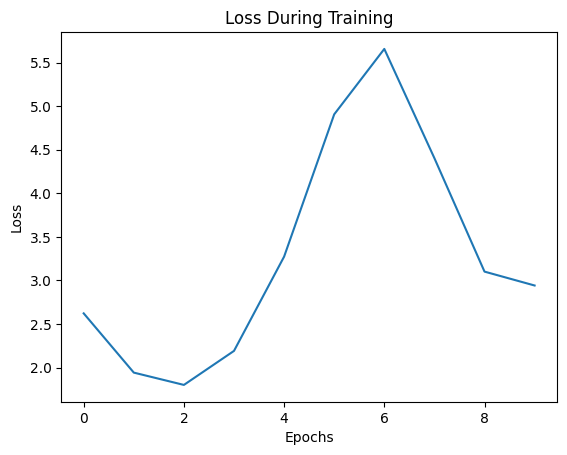

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step 


In [ ]:
# ---- TRAINING PARAMETERS ---- #
latent_dim = 128  # Controls the size of the compressed latent space. A higher value captures more detail.
num_embeddings = 32  # Number of unique codebook vectors available for quantization.
beta = 0.75
batch_size = 10
epochs = 10

# visualizing the model
vqvae_model = get_vqvae(latent_dim, num_embeddings, beta)
vqvae_model.summary()

# ---- MODEL TRAINING ---- #
# Compute variance of training data to normalize loss calculations.
train_variance = tf.math.reduce_variance(jazz_songs)

vqvae_trainer = VQVAETrainer(train_variance, latent_dim=latent_dim, num_embeddings=num_embeddings, beta=beta)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005))

initial_embeddings = vqvae_model.get_layer("vector_quantizer").embeddings.numpy().copy()  # Store initial embeddings

# Training:
history = vqvae_trainer.fit(jazz_songs, epochs=epochs, batch_size=batch_size)

# ---- VISUALIZATION ---- #
plt.plot(history.history['loss'])
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

pred_spectrograms_vqvae = vqvae_model.predict(jazz_songs)
jazz_df['pred_spectrogram_vqvae'] = pd.Series(pred_spectrograms_vqvae.tolist())
jazz_df.head()

### Another settings for the training:

In [ ]:
# ---- TRAINING PARAMETERS ---- #
latent_dim = 256  # Controls the size of the compressed latent space. A higher value captures more detail.
num_embeddings = 8  # Number of unique codebook vectors available for quantization.
beta = 0.5
batch_size = 10
epochs = 10

# visualizing the model
vqvae_model = get_vqvae(latent_dim, num_embeddings, beta)
vqvae_model.summary()

# ---- MODEL TRAINING ---- #
# Compute variance of training data to normalize loss calculations.
train_variance = tf.math.reduce_variance(jazz_songs)

vqvae_trainer = VQVAETrainer(train_variance, latent_dim=latent_dim, num_embeddings=num_embeddings, beta=beta)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005))

initial_embeddings = vqvae_model.get_layer("vector_quantizer").embeddings.numpy().copy()  # Store initial embeddings

# Training:
history = vqvae_trainer.fit(jazz_songs, epochs=epochs, batch_size=batch_size)

# ---- VISUALIZATION ---- #
plt.plot(history.history['loss'])
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

pred_spectrograms_vqvae = vqvae_model.predict(jazz_songs)
jazz_df['pred_spectrogram_vqvae'] = pd.Series(pred_spectrograms_vqvae.tolist())
jazz_df.head()

In [ ]:
# ---- EVALUATE RECONSTRUCTION QUALITY ---- #

# Higher values indicate better reconstructions.
jazz_df['cosine_similarity_vqvae'] = compute_cosine_similarity(jazz_df, 'gt_spectrogram', 'pred_spectrogram_vqvae')

sorted_similarities_vqvae = jazz_df['cosine_similarity_vqvae'].sort_values()
worst_idx_vqvae = jazz_df['cosine_similarity_vqvae'].idxmin()  
best_idx_vqvae = jazz_df['cosine_similarity_vqvae'].idxmax()   

print(f"Worst VQ-VAE Reconstruction Index: {worst_idx_vqvae}")
print(f"Best VQ-VAE Reconstruction Index: {best_idx_vqvae}")

print(jazz_df['cosine_similarity_vqvae'].describe())  # Expect higher values if reconstruction improves

# ---- AUDIO COMPARISON ---- #
def compare_song_audios_vqvae_and_save(jazz_df, sample_n, output_filename=None):
    try:
        pred_audio_vqvae = reconstruct_audio(
            jazz_df.iloc[sample_n]['pred_spectrogram_vqvae'],
            sr=22050, n_mels=128, min_max=jazz_df.iloc[sample_n]['min_max']
        )

        original_audio = jazz_df.iloc[sample_n]['gt_audio']

        # Normalize for 16-bit PCM (-32768 to 32767)
        pred_audio_int16 = np.int16(pred_audio_vqvae / np.max(np.abs(pred_audio_vqvae)) * 32767)

        # Save if output filename is provided
        if output_filename is not None:
            try:
                with sf.SoundFile(output_filename, mode='w', samplerate=22050, channels=1, subtype='PCM_16') as file:
                    file.write(pred_audio_int16)
                print(f"Saved audio to: {output_filename}")
            except Exception as e:
                print(f"Error saving {output_filename}: {e}")

        # Normalize for IPython Audio playback (IPython requires float32 in [-1,1])
        pred_audio_ipd = pred_audio_vqvae / np.max(np.abs(pred_audio_vqvae))

        return ipd.Audio(original_audio, rate=22050), ipd.Audio(pred_audio_ipd, rate=22050)

    except Exception as e:
        print(e)
        return None, None

real_vqvae, pred_vqvae = compare_song_audios_vqvae_and_save(jazz_df, best_idx_vqvae, output_filename="output/VQ-VAE_best.wav")
print("Best reconstruction")
display(real_vqvae)
display(pred_vqvae)

real_vqvae, pred_vqvae = compare_song_audios_vqvae_and_save(jazz_df, worst_idx_vqvae, output_filename="output/VQ-VAE_worst.wav")
print("worst reconstruction")
display(real_vqvae)
display(pred_vqvae)

# ---- VISUALIZING SPECTROGRAM RECONSTRUCTIONS ---- #
def plot_vqvae_spectrogram_comparison(jazz_df: pd.DataFrame, index: int):
    """
    Plots the original and VQ-VAE reconstructed spectrogram side by side.
    """
    fig, axes = plt.subplots(1, 2)

    # Original spectrogram
    axes[0].imshow(jazz_df.iloc[index]['gt_spectrogram'], origin='lower', aspect='auto')
    axes[0].set_title("Original Spectrogram")

    # VQ-VAE reconstructed spectrogram
    axes[1].imshow(jazz_df.iloc[index]['pred_spectrogram_vqvae'], origin='lower', aspect='auto')
    axes[1].set_title("VQ-VAE Reconstructed Spectrogram")

    plt.show()

# Plot and compare the worst and best reconstructions
plot_vqvae_spectrogram_comparison(jazz_df, worst_idx_vqvae)
plot_vqvae_spectrogram_comparison(jazz_df, best_idx_vqvae)

In [ ]:
# ---- CHECK EMBEDDING CHANGES OVER TRAINING ---- #

vq_layer = vqvae_model.get_layer("vector_quantizer")  # Ensure this matches the layer name
trained_embeddings = vq_layer.embeddings.numpy()

embedding_change = np.abs(trained_embeddings - initial_embeddings)

print("Initial vs. Trained Embeddings):")
for i in range(5):
    print(f"Embedding {i}:")
    print(f"  Initial: {initial_embeddings[i]}") 
    print(f"  Trained: {trained_embeddings[i]}") 
    print(f"  Change:  {embedding_change[i]}")  

# ---- CHECK HOW WELL EMBEDDINGS ARE UTILIZED ---- #
encoder = vqvae_model.get_layer("encoder") 
z_e = encoder.predict(jazz_songs)
try: 
    # Reshape encoder output to (batch_size * num_patches, latent_dim)
    z_e = z_e.reshape(-1, z_e.shape[-1]) 
    
    # Compute encoding indices 
    encoding_indices = np.argmin(
        np.sum(z_e**2, axis=1, keepdims=True)  
        - 2 * np.matmul(z_e, trained_embeddings.T)
        + np.sum(trained_embeddings**2, axis=0),  
        axis=1 
    )
    
    # Count the number of unique embeddings that were actually used during training
    unique_embeddings_used = len(np.unique(encoding_indices))
    print(f"Unique embeddings used: {unique_embeddings_used} / {num_embeddings}")
    
    
    plt.figure()
    plt.hist(encoding_indices, bins=num_embeddings, range=(0, num_embeddings - 1))
    plt.xlabel("Embedding Index")
    plt.ylabel("Usage Count")
    plt.title("Used Embedding Indices")
    plt.show()
    
    
    plt.figure()
    plt.hist(z_e.flatten(), bins=100)
    plt.title("Latent Space Activations")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()
except Exception as e:
    print (e)

The VQ-VAE training was unstable. The VQ loss kept increasing, even when the reconstruction loss improved. Experimenting with different beta values, batch sizes, and learning rates did not help. The main issue was poor embedding updates I think, likely due to batch normalization interfering with quantization or wrong implementation. Even after adjustments, the codebook usage remained low, meaning many embeddings were never assigned.


### So lets try another approach

Due to these challenges, we decided to use Hierarchical VAE (HVAE) instead. 
HVAE keeps the latent space continuous while adding an extra latent layer. This allows it to capture high-level and low-level features separately. HVAE is also easier to train than VQ-VAE since it does not rely on discrete representations. 

# Hierarchical VAE (HVAE) 

In [ ]:
def create_hvae():
    """
    Defines a Hierarchical VAE (HVAE) with two latent layers to capture hierarchical representations.
    """
    n_mels, time_frames = N_MELS, TIME_FRAMES
    latent_dim_1 = 64  # Higher-level features
    latent_dim_2 = 32  # Lower-level details

    # ---- ENCODER ---- #
    encoder_input = Input(shape=(n_mels, time_frames))
    encoder_flatten = Flatten()(encoder_input)

    # First latent layer (z1)
    z1_mean = Dense(latent_dim_1, activation="linear")(encoder_flatten)
    z1_log_var = Dense(latent_dim_1, activation="linear")(encoder_flatten)

    def sampling(args):
        mean, log_var = args
        batch = K.shape(mean)[0]
        dim = K.int_shape(mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return mean + K.exp(0.5 * K.clip(log_var, -10, 10)) * epsilon  # Clip to prevent NaNs

    z1 = Lambda(sampling, output_shape=(latent_dim_1,))([z1_mean, z1_log_var])

    # Second latent layer (z2) based on z1
    z2_mean = Dense(latent_dim_2, activation="linear")(z1)
    z2_log_var = Dense(latent_dim_2, activation="linear")(z1)
    z2 = Lambda(sampling, output_shape=(latent_dim_2,))([z2_mean, z2_log_var])

    encoder = Model(encoder_input, [z1_mean, z1_log_var, z2_mean, z2_log_var, z1, z2], name="encoder")

    # ---- DECODER ---- #
    decoder_input = Input(shape=(latent_dim_2,))
    decoder_dense = Dense(n_mels * time_frames, activation="sigmoid")(decoder_input)
    decoder_reshaped = Reshape((n_mels, time_frames))(decoder_dense)
    decoder = Model(decoder_input, decoder_reshaped, name="decoder")

    # ---- LOSS FUNCTION ---- #
    def hvae_loss_function(args):
        """
        Computes the HVAE loss with reconstruction loss and KL divergence.
        """
        y_true, y_pred, z1_mean, z1_log_var, z2_mean, z2_log_var = args
        
        reconstruction_loss = K.mean(K.square(y_true - y_pred))

        kl_loss_z1 = -0.5 * K.mean(1 + K.clip(z1_log_var, -10, 10) - K.square(z1_mean) - K.exp(K.clip(z1_log_var, -10, 10)))   #(Ensure numerical stability)
        kl_loss_z2 = -0.5 * K.mean(1 + K.clip(z2_log_var, -10, 10) - K.square(z2_mean) - K.exp(K.clip(z2_log_var, -10, 10)))

        return reconstruction_loss + kl_loss_z1 + kl_loss_z2

    # ---- FULL HVAE MODEL ---- #
    hvae_input = Input(shape=(n_mels, time_frames))
    hvae_target = Input(shape=(n_mels, time_frames))

    encoder_output = encoder(hvae_input)
    decoder_output = decoder(encoder_output[5])  # Use z2 for final reconstruction

    # Add loss function to model
    loss = Lambda(hvae_loss_function, output_shape=(1,), name='loss')(
        [hvae_target, decoder_output, encoder_output[0], encoder_output[1], encoder_output[2], encoder_output[3]]
    )
    
    hvae = Model(inputs=[hvae_input, hvae_target], outputs=[decoder_output, loss])
    
    return hvae

In [ ]:
# Prepare dataset
jazz_songs = np.array(jazz_df['gt_spectrogram'].tolist())

# Set hyperparameters
batch_size = 10
epochs = 100

# Compile the HVAE
hvae = create_hvae()
hvae.compile(optimizer=Adam(learning_rate=0.001), loss=['mse', None])

# Train the HVAE
history_hvae = hvae.fit([jazz_songs, jazz_songs], [jazz_songs, np.zeros_like(jazz_songs)],
                        epochs=epochs,
                        batch_size=batch_size)

# Plot training loss
plt.plot(history_hvae.history['loss'])
plt.title('Loss During Training (HVAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation of HVAE

In [ ]:
pred_spectrograms_hvae, _ = hvae.predict([jazz_songs, jazz_songs])
jazz_df['pred_spectrogram_hvae'] = pd.Series(pred_spectrograms_hvae.tolist())

jazz_df['cosine_similarity_hvae'] = compute_cosine_similarity(jazz_df, 'gt_spectrogram', 'pred_spectrogram_hvae')

# Find best and worst reconstructions for HVAE
worst_idx_hvae = jazz_df['cosine_similarity_hvae'].idxmin()
best_idx_hvae = jazz_df['cosine_similarity_hvae'].idxmax()

print(f"Worst HVAE Reconstruction Index: {worst_idx_hvae}")
print(f"Best HVAE Reconstruction Index: {best_idx_hvae}")

print(jazz_df['cosine_similarity_hvae'].describe())  # Summarize similarity scores


In [ ]:
def compare_song_audios_hvae_and_save(jazz_df, sample_n, output_filename=None):
    try:
        pred_audio_hvae = reconstruct_audio(
            jazz_df.iloc[sample_n]['pred_spectrogram_hvae'],
            sr=22050, n_mels=128, min_max=jazz_df.iloc[sample_n]['min_max']
        )

        original_audio = jazz_df.iloc[sample_n]['gt_audio']

        pred_audio_int16 = (pred_audio_hvae / np.max(np.abs(pred_audio_hvae)) * 32767).astype(np.int16)

        # Save if output filename is provided
        if output_filename is not None:
            try:
                sf.write(output_filename, pred_audio_int16, 22050)
                print(f"Saved audio to: {output_filename}")
            except Exception as e:
                print(f"Error saving {output_filename}: {e}")

        # Normalize for IPython Audio playback (IPython requires float32 in [-1,1])
        pred_audio_ipd = pred_audio_hvae / (np.max(np.abs(pred_audio_hvae)) + 1e-7)

        return ipd.Audio(original_audio, rate=22050), ipd.Audio(pred_audio_ipd, rate=22050)

    except Exception as e:
        print(e)
        return None, None

print("Worst:")
real_hvae, pred_hvae = compare_song_audios_hvae_and_save(jazz_df, worst_idx_hvae, output_filename="output/HVAE_worst.wav")
display(real_hvae)
display(pred_hvae)

print("Best:")
real_hvae, pred_hvae = compare_song_audios_hvae_and_save(jazz_df, best_idx_hvae, output_filename="output/HVAE_best.wav")
display(real_hvae)
display(pred_hvae)


In [ ]:
def plot_hvae_spectrogram_comparison(jazz_df: pd.DataFrame, index: int):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(jazz_df.iloc[index]['gt_spectrogram'], origin='lower', aspect='auto')
    axes[0].set_title("Original Spectrogram")

    # HVAE  
    axes[1].imshow(jazz_df.iloc[index]['pred_spectrogram_hvae'], origin='lower', aspect='auto')
    axes[1].set_title("HVAE Reconstructed Spectrogram")

    plt.show()

plot_hvae_spectrogram_comparison(jazz_df, worst_idx_hvae)
plot_hvae_spectrogram_comparison(jazz_df, best_idx_hvae)


In [ ]:
plt.figure()

plt.hist(jazz_df['cosine_similarity'], bins=50, alpha=0.6, label="Vanilla VAE", color="blue")
plt.hist(jazz_df['cosine_similarity_hvae'], bins=50, alpha=0.6, label="HVAE", color="red")

plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("Cosine Similarity Distribution: Vanilla VAE vs HVAE")
plt.legend()
plt.show()


In [ ]:
print(f"Vanilla VAE Best Similarity: {jazz_df['cosine_similarity'].max():.4f}")
print(f"HVAE Best Similarity: {jazz_df['cosine_similarity_hvae'].max():.4f}")

print(f"Vanilla VAE Worst Similarity: {jazz_df['cosine_similarity'].min():.4f}")
print(f"HVAE Worst Similarity: {jazz_df['cosine_similarity_hvae'].min():.4f}")


The random sampling with added noise from the latent space lead to poor results.

If the reconstruction quality is poor, then the model is fundamentally not learning meaningful representations. This means the issue is not in the sampling process but in the training and model architecture itself.



# VAE with Simple Waveforms

For one final approach, we can maintain a simpler architecture but adopt a new data representation which analyzes the waveform itself instead of a spectrogram.

In [ ]:
audio_lengths = [len(audio) for audio in jazz_df['gt_audio']]
print(f"Max length: {max(audio_lengths)}, Min length: {min(audio_lengths)}, Median length: {np.median(audio_lengths)}")


In [ ]:

from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Dense, Lambda, GlobalAveragePooling1D, BatchNormalization, Reshape, UpSampling1D

# ---- HYPERPARAMETERS ---- #
sequence_length = (1280 //8) * 8 # Number of waveform samples, making sure it can be devided by 8
latent_dim = 8  

# ---- MODEL ARCHITECTURE ---- #
def get_encoder(sequence_length, latent_dim):
    """
    Encoder for 1D waveform processing using Conv1D layers.
    """
    encoder_input = Input(shape=(sequence_length, 1))

    x = Conv1D(64, kernel_size=3, strides=2, activation="relu", padding="same")(encoder_input)
    x = Conv1D(128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv1D(256, kernel_size=3, strides=2, activation="relu", padding="same")(x)

    # Flattening lead to milions paramters, instead we are trying Global Average Pooling 
    x = GlobalAveragePooling1D()(x)

    z_mean = Dense(latent_dim, activation="linear")(x)
    z_mean = BatchNormalization()(z_mean)  # Helps latent stability
    z_log_var = Dense(latent_dim, activation="linear")(x)
    
    def sampling(args):
        mean, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean), mean=0.0, stddev=0.1)  

        return mean + K.exp(0.5 * K.clip(log_var, -10, 10)) * epsilon  # Clipping for numerical stability

    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    return encoder

def get_decoder(sequence_length, latent_dim):
    decoder_input = Input(shape=(latent_dim,))

    target_shape = (sequence_length // 8, 256)  # Adjust based on encoder downsampling
    x = Dense(np.prod(target_shape), activation="relu")(decoder_input)
    x = Reshape(target_shape)(x)  # (batch, time_steps//8, 128)

    x = Conv1DTranspose(256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv1DTranspose(128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv1DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same")(x)

    # Final reconstruction layer
    x = Conv1DTranspose(1, kernel_size=3, strides=1, activation="tanh", padding="same")(x)
    
    decoder = Model(decoder_input, x, name="decoder")
    return decoder

class VAE(Model):
    def __init__(self, encoder, decoder, sequence_length, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sequence_length = sequence_length
        self.latent_dim = latent_dim

    def vae_loss_function(self, y_true, y_pred, z_mean, z_log_var):
        y_true = K.reshape(y_true, K.shape(y_pred))

        reconstruction_loss = K.mean(K.square(y_true - y_pred))

        beta = 1 
        kl_loss = -0.5 * K.mean(1 + K.clip(z_log_var, -10, 10) - K.square(z_mean) - K.exp(K.clip(z_log_var, -10, 10)))

        return reconstruction_loss + beta * kl_loss
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)
            loss = self.vae_loss_function(data, reconstructed, z_mean, z_log_var)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"loss": loss}

    def call(self, inputs):
        """Defines how the VAE processes input during inference."""
        z_mean, z_log_var, z = self.encoder(inputs) 
        reconstructed = self.decoder(z)  
        return reconstructed  

def create_vae(sequence_length, latent_dim):
    encoder = get_encoder(sequence_length, latent_dim)
    decoder = get_decoder(sequence_length, latent_dim)
    vae = VAE(encoder, decoder, sequence_length, latent_dim)
    return vae, encoder, decoder

# ---- LOAD DATA ---- #
def split_audio_into_chunks(waveform, chunk_size, stride):
    """Splits long waveforms into overlapping chunks."""
    num_chunks = max(1, (len(waveform) - chunk_size) // stride + 1)
    chunks = [waveform[i * stride: i * stride + chunk_size] for i in range(num_chunks)]
    return chunks

def normalize_audio(waveform):
    """Normalize waveform between -1 and 1."""
    return waveform / np.max(np.abs(waveform)) 

jazz_waveforms = []
for w in jazz_df['gt_audio']:
    normalized_w = normalize_audio(w) 
    jazz_waveforms.extend(split_audio_into_chunks(normalized_w, chunk_size=sequence_length, stride=sequence_length*2))

jazz_waveforms = np.array(jazz_waveforms)
jazz_waveforms = np.expand_dims(jazz_waveforms, axis=-1)  # Shape: (batch_size, time_steps, 1)

print(f"Data input shape: {jazz_waveforms.shape}") 

# ---- TRAIN ---- #
# Instantiate the VAE model
vae, encoder, decoder = create_vae(sequence_length, latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0))

history = vae.fit(jazz_waveforms, epochs=10, batch_size=100)  

# ---- VISUALIZATION ---- #
plt.plot(history.history['loss'])
plt.title('Loss During Training (VAE - Waveform)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
import seaborn as sns

z_means, z_log_vars, z_samples = encoder.predict(jazz_waveforms)
print("Mean of latent variables (z):", np.mean(z_samples, axis=0))  # Should not be all zeros
print("Variance of latent variables:", np.var(z_samples, axis=0))  # Should not be too small

z_means, _, z_samples = encoder.predict(jazz_waveforms)
plt.figure()
sns.histplot(z_samples.flatten(), bins=50, kde=True)
plt.title("Latent Space Distribution")
plt.show()


In [ ]:
# ---- EVALUATION ---- #
def compute_mse(df, col1, col2):
    # to use in addition to cosine similarity
    errors = []
    
    for idx, row in df.iterrows():
        waveform1 = np.array(row[col1])
        waveform2 = np.array(row[col2])
        
        if waveform1.size == 0 or waveform2.size == 0:
            errors.append(np.nan)
            continue
        
        length_diff = len(waveform1) - len(waveform2)
        if abs(length_diff) > 500:  # If difference is too large, just skip it
            errors.append(np.nan)
            continue
        
        # Pad the shorter waveform if needed
        if length_diff > 0:  # waveform1 is longer
            waveform2 = np.pad(waveform2, (0, length_diff), mode='constant')
        elif length_diff < 0:  # waveform2 is longer
            waveform1 = np.pad(waveform1, (0, -length_diff), mode='constant')

        errors.append(np.mean(np.square(waveform1 - waveform2)))
    
    return np.array(errors)

pred_waveforms = vae.predict(jazz_waveforms)
jazz_df['pred_waveform'] = pd.Series(pred_waveforms.tolist())
jazz_df['cosine_similarity'] = compute_cosine_similarity(jazz_df, 'gt_audio', 'pred_waveform')

if jazz_df['cosine_similarity'].isna().all():
    print("All cosine similarities are NaN!")
    worst_idx, best_idx = None, None
else:
    worst_idx = jazz_df['cosine_similarity'].idxmin(skipna=True)
    best_idx = jazz_df['cosine_similarity'].idxmax(skipna=True)

jazz_df['mse_loss'] = compute_mse(jazz_df, 'gt_audio', 'pred_waveform')

# Identify best and worst samples based on MSE
print("using MSE:", jazz_df['mse_loss'].idxmax(), "\nusing cosine:", worst_idx)  # Worst = highest error
print("using MSE:", jazz_df['mse_loss'].idxmin(), "\nusing cosine:", best_idx)   # Best = lowest error

# Compare Generated Audio
def compare_audio(jazz_df, idx):
    pred_audio = jazz_df.iloc[idx]['pred_waveform']
    real_audio = jazz_df.iloc[idx]['gt_audio']
    return ipd.Audio(real_audio, rate=22050), ipd.Audio(pred_audio, rate=22050)

print("Worst:")
display(*compare_audio(jazz_df, worst_idx))

print("Best:")
display(*compare_audio(jazz_df, best_idx))
